# Fuse

This tutorial provides users with an overview of how to use fuses in pandapower networks. 

## General Overview
The steps to using fuses in pandapower networks are as follows:
1. Create a pandapower network. When creating the network, use create_switch() or create_switches() to create a switch at each fuse location. Evaluate whether the switch is bus-line, bus-trafo, or bus-bus, and specify the location accordingly. 
2. Create the fuses by calling the Fuse() class. Enter the corresponding switch index and fuse type.
3. Perform a protection calculation by calling calculate_protection_times(). 

## Fuse for Short-Circuit Protection

### Example Network 1

First, we create a radial pandapower network as shown below.


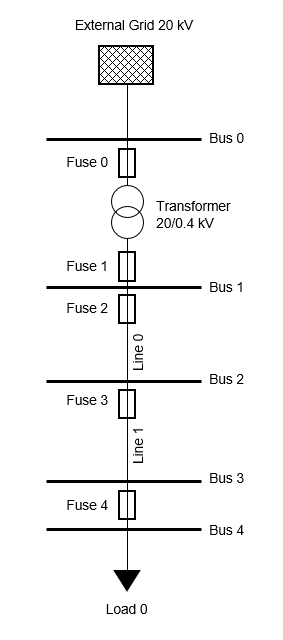

In [1]:
import pandapower as pp

def fuse_example_net1():
    net = pp.create_empty_network()
    # create buses
    pp.create_buses(net, nr_buses=4, vn_kv=[20, 0.4, 0.4, 0.4, 0.4], index=[0, 1, 2, 3, 4], name=None, type="n",
                    geodata=[(0, 0), (0, -2), (0, -4), (0, -6), (0, -8)])
    
    # create external grid
    pp.create_ext_grid(net, 0, vm_pu=1.0, va_degree=0, s_sc_max_mva=100, s_sc_min_mva=50, rx_max=0.1, rx_min=0.1)
    pp.create_lines_from_parameters(net, from_buses=[1, 2], to_buses=[2, 3], length_km=[0.1, 0.1], r_ohm_per_km=0.2067,
                                    x_ohm_per_km=0.080424, c_nf_per_km=261, name=None, index=[0, 1], max_i_ka=0.27)
    
    net.line["endtemp_degree"] = 250
    # create transformer
    pp.create_transformer(net, hv_bus=0, lv_bus=1, std_type="0.63 MVA 20/0.4 kV")
    
    # Define trafo fuses
    pp.create_switches(net, buses=[0, 1], elements=[0, 0], et='t', type="fuse")
    
    # Define line fuses
    pp.create_switches(net, buses=[1, 2], elements=[0, 1], et='l', type="fuse")
    
    # Define load fuse (bus-bus switch)
    pp.create_switch(net, bus=3, element=4, et='b', type="fuse", z_ohm=0.0001)
    
    # define load
    pp.create_load(net, bus=4, p_mw=0.1, q_mvar=0, const_z_percent=0, const_i_percent=0, sn_mva=.1,
                   name=None, scaling=1., index=0)
    return net

net = fuse_example_net1()
net

This pandapower network includes the following parameter tables:
   - bus (5 element)
   - load (1 elements)
   - switch (5 element)
   - ext_grid (1 elements)
   - line (2 element)
   - trafo (1 elements)
   - bus_geodata (5 element)

### Add Fuses to Network

Users can add fuses to a network by calling the Fuse class. 

    INPUT:
        **net** (attrdict) - pandapower net

        **switch_index** (int) - index of the switch that the fuse acts upon

    OPTIONAL:

        **fuse_type** (str, "none") - string of the fuse type to be used. If it is in the standard library, it
        automatically generates the characteristic curve. Otherwise, it has no effect.
        Example: fuse_type = "Siemens NH-1-100"

        **rated_i_a** (float, 0) - the rated current of the fuse in amps

        **characteristic_index** (int, 0) - index of the corresponding characteristic curve. It is automatically generated
        when characteristic curve is created.

        **in_service** (bool, True) - indicates if fuse is currently in service and should be included in protection
        computations

        **overwrite** (bool, False) - indicates if fuse should replace already existing protection device acting upon
        switch

        **curve_select** (int, 0) - specifies which curve should be used as characteristic curve. This only has an
        effect for fuses that contain two different melting curves (t_min and t_total). For fuses that only have one
        characteristic curve (t_avg), curve_select has no effect.

        **z_ohm** (float, 0.0001) - gives the resistance of the fuse in ohms. This is used in calculations for bus-bus
        switches

        **name** (str, None) - name of the fuse. For example, name = "Line 2 Fuse"

Pandapower contains a standard library of fuses with rated currents ranging from 6.3 A to 1000 A. To add a fuse from the standard library to the network, specify the fuse type when creating the fuse. Additional fuse types can be added by users to the standard library by calling the create_std_type() function. When dealing with additional fuse types, it is recommended to add them to the standard library instead of specifying the parameters when calling the Fuse() class. 

In our example, we will create one new fuse type to use on the HV side of the transformer, and then use 4 fuse types from the pandapower standard library for the remaining switches in the network. 

In [2]:
from pandapower.protection.protection_devices.fuse import Fuse
from pandapower import create_std_type

# create dictionary that will be used to add new fuse to standard library
# this data is the same as the HV 63A found in the standard library
new_fuse_data = {'fuse_type': 'New Fuse',
                'i_rated_a': 63.0,
                't_avg': 0,
                't_min': [10.0, 2.84, 0.368, 0.164, 0.1, 0.0621, 0.0378, 0.0195, 0.01],
                't_total': [10.0, 1.82, 0.344, 0.1, 0.0467, 0.0269, 0.01],
                'x_avg': 0,
                'x_min': [189.0, 220.0, 300.0, 350.0, 393.0, 450.0, 530.0, 700.0, 961.0],
                'x_total': [378.0, 500.0, 700.0, 934.0, 1200.0, 1500.0, 2366.0]}

# create new standard fuse type
create_std_type(net, data=new_fuse_data, name='New Fuse', element="fuse")

# create list with the fuse types to be added to the network
fuse_type_list = ["New Fuse", "Siemens NH-2-630", "Siemens NH-2-425", "Siemens NH-2-315", "Siemens NH-2-224"]

# add fuses to network
for k in range(5):
    Fuse(net=net, switch_index=k, fuse_type=fuse_type_list[k])

### Run Short-circuit Scenario
To find the melting times of a fuse in a short-circuit scenario, we first run a short circuit calculation at the desired location in the network. In this example, we run the short circuit calculation at bus 3. When calling sc.calc_sc, make sure to specify branch_results = True.

In [3]:
import pandapower.shortcircuit as sc
sc.calc_sc(net, bus=3, branch_results=True)

Branch results are in beta mode and might not always be reliable, especially for transformers


Then, call calculate_protection_times(). By default, this function assumes a short circuit scenario. The results are stored in a dataframe with columns for the switch index (switch_id), protection device type (prot_type), whether or not the device tripped/melted (trip_melt), the activation parameter (act_param, current in kA for fuses) and its value (act_param_val), and the trip/melt time in seconds (trip_melt_time_s). For devices that do not trip/melt in the scenario, the trip/melt time results in infinity.  

In [4]:
from pandapower.protection.run_protection import calculate_protection_times
protection_results = calculate_protection_times(net)
protection_results

,switch_id,protection_type,trip_melt,activation_parameter,activation_parameter_value,trip_melt_time_s
0,0,Fuse,False,i_ka,0.091661,inf
1,1,Fuse,True,i_ka,4.583029,8.301109
2,2,Fuse,True,i_ka,4.583029,1.037601
3,3,Fuse,True,i_ka,4.583029,0.145108
4,4,Fuse,False,i_ka,0.000000,inf


We see that Fuse 3 melts in 0.145108 seconds. After the fuse melts, the fault is cleared. Fuse 2 serves as a backup in case Fuse 3 fails to melt properly, and Fuse 1 serves as a backup for Fuse 2. 

## Fuse for Overload Protection
In this example, we create a meshed network with an open disconnecting switch, i.e., the network behaves as two radial branches after the transformer. We simulate a fault occurring in one branch, which melts a fuse. After the fault is cleared, the disconnecting switch is closed to continue providing power to both of the loads. However, we demonstrate that this results in an overload melting of another fuse, which disconnects both loads from the external grid. This result shows a cascading overload effect after a short-circuit event.

### Example Network 2: Overload Protection and Cascading Effect

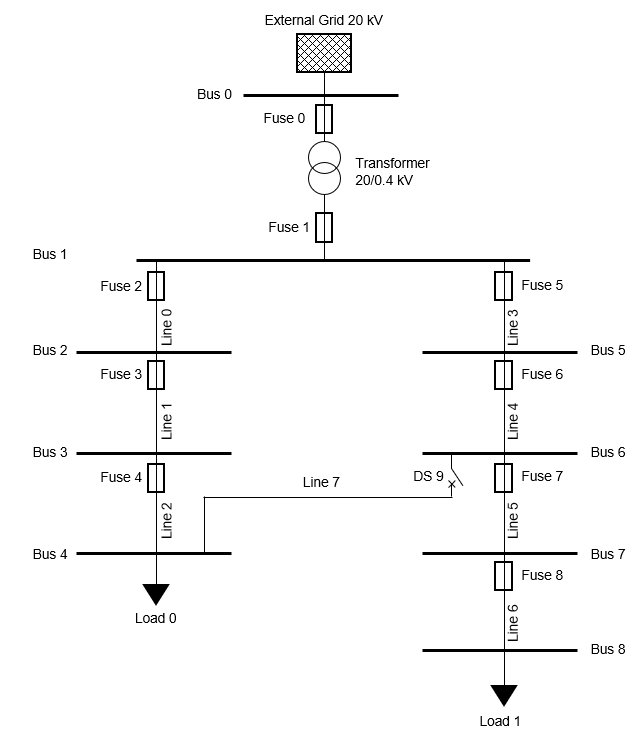

In [5]:
def fuse_example_net2():
    net = pp.create_empty_network()

    # create buses
    pp.create_buses(net, nr_buses=9, vn_kv=[20, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
                    index=[0, 1, 2, 3, 4, 5, 6, 7, 8], name=None, type="n",
                    geodata=[(0, 0), (0, -2), (-2, -4), (-2, -6), (-2, -8), (2, -4), (2, -6), (2, -8), (2, -10)])

    # create external grid
    pp.create_ext_grid(net, 0, vm_pu=1.0, va_degree=0, s_sc_max_mva=500, s_sc_min_mva=80, rx_max=0.1, rx_min=0.1)

    # create lines
    pp.create_lines(net, from_buses=[1, 2, 3, 1, 5, 6, 7, 6], to_buses=[2, 3, 4, 5, 6, 7, 8, 4],
                    length_km=[0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1], std_type="94-AL1/15-ST1A 0.4")

    net.line["endtemp_degree"] = 250

    # create transformer
    pp.create_transformer(net, hv_bus=0, lv_bus=1, std_type="0.25 MVA 20/0.4 kV")

    # define trafo fuses
    pp.create_switches(net, buses=[0, 1], elements=[0, 0], et='t', type="fuse")

    # define line fuses
    pp.create_switches(net, buses=[1, 2, 3, 1, 5, 6, 7], elements=[0, 1, 2, 3, 4, 5, 6], et='l', type="fuse")

    # define disconnecting switch
    pp.create_switch(net, bus=6, element=7, et='l', type="DS", closed=False)

    # define load
    pp.create_loads(net, buses=[3, 4], p_mw=[0.1, 0.05], q_mvar=0, const_z_percent=0, const_i_percent=0, name=None,
                    index=[0, 1])

    return net

net = fuse_example_net2()
net

This pandapower network includes the following parameter tables:
   - bus (9 element)
   - load (2 element)
   - switch (10 element)
   - ext_grid (1 elements)
   - line (8 element)
   - trafo (1 elements)
   - bus_geodata (9 element)

In [6]:
# assign fuses to switches
fuse_list = ['HV 25A', 'Siemens NH-2-400', 'Siemens NH-2-250', 'Siemens NH-2-224', 'Siemens NH-2-200',
             'Siemens NH-1-160', 'Siemens NH-1-125', 'Siemens NH-1-100', 'Siemens NH-1-80']
for k in range(9):
    Fuse(net=net, switch_index=k, fuse_type=fuse_list[k])

In [7]:
# perform short circuit calculation at bus 3
sc.calc_sc(net, bus=3, branch_results=True)

# calculate protection times
protection_results = calculate_protection_times(net, scenario='sc')
protection_results

Branch results are in beta mode and might not always be reliable, especially for transformers


,switch_id,protection_type,trip_melt,activation_parameter,activation_parameter_value,trip_melt_time_s
0,0,Fuse,False,i_ka,0.025071,inf
1,1,Fuse,True,i_ka,1.253539,172.163614
2,2,Fuse,True,i_ka,1.253539,20.097236
3,3,Fuse,True,i_ka,1.253539,13.274965
4,4,Fuse,False,i_ka,0.000000,inf
5,5,Fuse,False,i_ka,0.000000,inf
6,6,Fuse,False,i_ka,0.000000,inf
7,7,Fuse,False,i_ka,0.000000,inf
8,8,Fuse,False,i_ka,0.000000,inf


In [8]:
 # for fuse with the fastest melting time, melt the corresponding switch
net.protection.object.at[protection_results.trip_melt_time_s.idxmin()].status_to_net(net)

# check switch status
net.switch

,bus,element,et,type,closed,name,z_ohm,in_ka
0,0,0,t,fuse,True,None,0.0001,NaN
1,1,0,t,fuse,True,None,0.0001,NaN
2,1,0,l,fuse,True,None,0.0001,NaN
3,2,1,l,fuse,False,None,0.0001,NaN
4,3,2,l,fuse,True,None,0.0001,NaN
5,1,3,l,fuse,True,None,0.0001,NaN
6,5,4,l,fuse,True,None,0.0001,NaN
7,6,5,l,fuse,True,None,0.0001,NaN
8,7,6,l,fuse,True,None,0.0001,NaN
9,6,7,l,DS,False,None,0.0000,NaN


In [9]:
# after fault is cleared, close the CB at bus 6 so that Load 0 continues to get power
net.switch.closed.at[9] = True

net.switch

,bus,element,et,type,closed,name,z_ohm,in_ka
0,0,0,t,fuse,True,None,0.0001,NaN
1,1,0,t,fuse,True,None,0.0001,NaN
2,1,0,l,fuse,True,None,0.0001,NaN
3,2,1,l,fuse,False,None,0.0001,NaN
4,3,2,l,fuse,True,None,0.0001,NaN
5,1,3,l,fuse,True,None,0.0001,NaN
6,5,4,l,fuse,True,None,0.0001,NaN
7,6,5,l,fuse,True,None,0.0001,NaN
8,7,6,l,fuse,True,None,0.0001,NaN
9,6,7,l,DS,True,None,0.0000,NaN


After the fault is cleared, the grid resumes normal power flow. We now check to see if any of the fuses melt due to potential overload effects. 

In [10]:
# perform power flow calculation
pp.runpp(net)

# check if any fuses melt during regular power flow after fault has been cleared
overload_results = calculate_protection_times(net, scenario="pp")
overload_results

,switch_id,protection_type,trip_melt,activation_parameter,activation_parameter_value,trip_melt_time_s
0,0,Fuse,False,i_ka,5.166588e-03,inf
1,1,Fuse,False,i_ka,2.571970e-01,inf
2,2,Fuse,False,i_ka,1.884067e-07,inf
3,3,Fuse,False,i_ka,0.000000e+00,inf
4,4,Fuse,False,i_ka,1.746698e-01,inf
5,5,Fuse,True,i_ka,2.571971e-01,2134.851997
6,6,Fuse,True,i_ka,2.571971e-01,922.963413
7,7,Fuse,False,i_ka,1.741893e-07,inf
8,8,Fuse,False,i_ka,8.709467e-08,inf


We see that Fuse 6 melts in the fastest amount of time. We modify the network accordingly. 

In [11]:
# fastest-melting fuse opens switch
net.protection.object.at[overload_results.trip_melt_time_s.idxmin()].status_to_net(net)

net.switch

,bus,element,et,type,closed,name,z_ohm,in_ka
0,0,0,t,fuse,True,None,0.0001,NaN
1,1,0,t,fuse,True,None,0.0001,NaN
2,1,0,l,fuse,True,None,0.0001,NaN
3,2,1,l,fuse,False,None,0.0001,NaN
4,3,2,l,fuse,True,None,0.0001,NaN
5,1,3,l,fuse,True,None,0.0001,NaN
6,5,4,l,fuse,False,None,0.0001,NaN
7,6,5,l,fuse,True,None,0.0001,NaN
8,7,6,l,fuse,True,None,0.0001,NaN
9,6,7,l,DS,True,None,0.0000,NaN


After fuse 6 melted, there is no path for power to flow to either load. This is confirmed when we run a power flow calculation of the grid after this change. 

In [12]:
# run power flow one more time
pp.runpp(net)

# loads are no longer powered
net.res_load

,p_mw,q_mvar
0,0.0,0.0
1,0.0,0.0


## Plotting Fuse Characteristic Curves

To plot a fuse characteristic curve, call the Fuse.plot_protection_characteristic() method. 

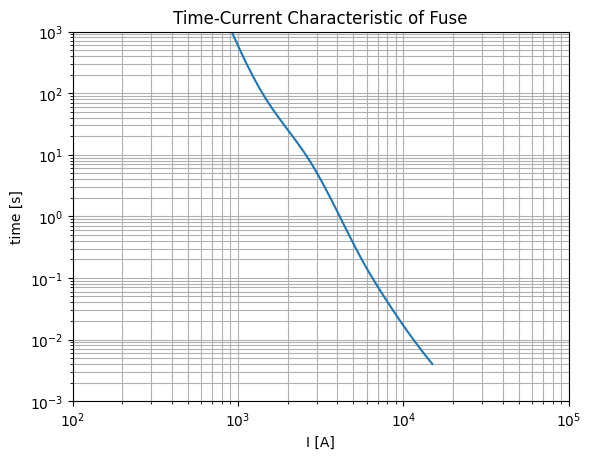

In [13]:
import matplotlib.pyplot as plt

plt.figure(1)
net.protection.object.at[1].plot_protection_characteristic(net)
plt.show()

To add multiple fuse characteristics and currents, use a for loop and the results from calculate_protection_times().

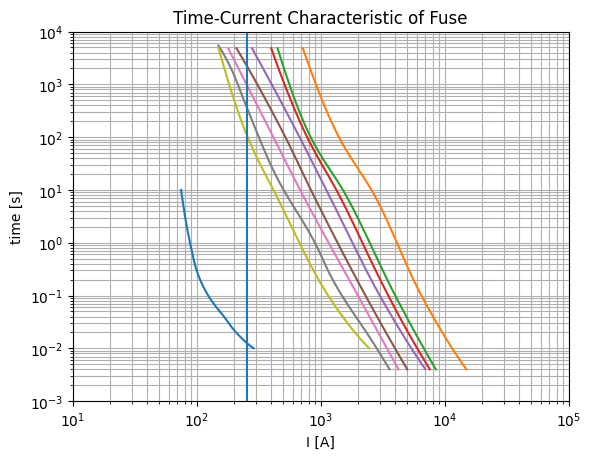

In [14]:
plt.figure(2)

# plot characteristic curve for each fuse in net
protection_devices = net.protection.query("in_service").object.values
for p in protection_devices:
    p.plot_protection_characteristic(net)

# reset plot limits manually
plt.xlim(10, 100000)
plt.ylim(0.001, 10000)

# add overload current at Fuse 6
plt.axvline(overload_results.activation_parameter_value.at[6]*1000)

# show plot
plt.show()
